[371.0355, 235.60208333333333, 142.044175, 179.41700866666667, 264.26591666666667, 510.0043733333333, 757.1337203333333, 954.446252, 1159.0202916666667, 1367.1452266666668, 1581.3221833333332, 1797.889315, 2018.3082733333333]


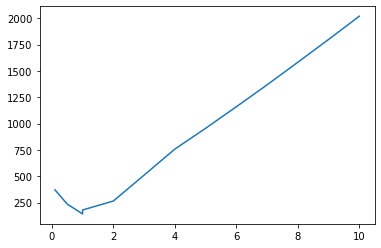

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat

#values used for costs
L_H=[(0.1,100,1),(0.5,150,1.5),(1,225,2.25),(1,1034,10.34),(2,4750,47.5),(3,11023,110.23),(4,16971,169.71),(5,21692,216.92),(6,26509,265.09),(7,31408,314.08),(8,36377,363.77),(9,41409,414.09),(10,46498,464.98)] #h_d;C_i;C_m
L_S=[(-100,-0.1,0,0),(-0.1,0,0,0.1),(0,0.5,150000,0.5),(0.5,1,1500000,1),(1,1.5,2000000,1),(1.5,100,2000000,1)]# S_min;S_max;C_s;C_g-percentage

# Constants
L = 5000    # Length of section (m)
B = 300     # Watercourse width (m)
Zb = 55.5  # Shoreline elevation (m NGF)
T=30        # Considered time span

# Simulation parameters 
vec_size = 100000                # Points to generate
mode_Q, scale_Q = 1013, 558 # Q law (Gumbel)
exp_K, std_K = 30, 7.5      # Ks law (Gaussian)
exp_Zv, hr_Zv = 50, 1       # Zv law (Triangular)
exp_Zm, hr_Zm = 55, 1       # Zm law (Triangular)

# Generate random variables vectors
Q_vec = stat.gumbel_r.rvs(loc=mode_Q, scale=scale_Q, size=vec_size)
Ks_vec = stat.norm.rvs(loc=exp_K, scale=std_K, size=vec_size)
Zv_vec = stat.triang.rvs(c=1/2, loc=exp_Zv-hr_Zv, scale=2*hr_Zv, size=vec_size)
Zm_vec = stat.triang.rvs(c=1/2, loc=exp_Zm-hr_Zm, scale=2*hr_Zm, size=vec_size)

to_remove_ind = [] # List of indexes that violate positivity criteria
for i in range(len(Q_vec)):
    
    if Q_vec[i]<=0:
        to_remove_ind.append(i)
    if Ks_vec[i]<=1:
        to_remove_ind.append(i)
to_remove_ind = np.array(to_remove_ind)

# Removing these indices from the dataset
Q_vec = np.delete(Q_vec, to_remove_ind)
Ks_vec = np.delete(Ks_vec, to_remove_ind)
Zv_vec = np.delete(Zv_vec, to_remove_ind)
Zm_vec = np.delete(Zm_vec, to_remove_ind)
H_vec = (Q_vec/(Ks_vec*B*np.sqrt((Zm_vec-Zv_vec)/L)))**(3/5)
S = Zv_vec + H_vec - Zb

H=[]        #list of suggested heights
L_C=[]      #list of costs

for i in range(len(L_H)):
    H+=[L_H[i][0]]
    S1=S-L_H[i][0]  #Overflow in relation to the dike
    Sc=[0,0,0,0,0,0]   #empirical density
    for j in range(len(S1)): #histogram construction
        for k in range(len(L_S)):
            if S1[j]<L_S[k][1] and S1[j]>L_S[k][0]:
                Sc[k]+=1
                break
    for k in range(len(Sc)): #normalization
        Sc[k]=Sc[k]/vec_size
    C=0                     #cost
    for j in range(len(L_S)):
        C+=(L_S[j][2]+L_H[i][1]*L_S[j][3]*T)*Sc[j] # adding the cost that depends on the overflow S according to its density
    C+=(L_H[i][1]+T*L_H[i][2]) #adding the total cost of investment and maintenance accumulated over T with no regards to damage
    C=C/T   #mean cost over T
    L_C+=[C]

print(L_C)

plt.plot(H,L_C)